# 1. Set the path for the files

In [1]:
# library
import os

# import os
path = os.getcwd()

# path to the smoothed time series
path_smooth = path+"/00_database/03_smoothed/table.csv"

# path with satellite time series file
path_aux = path+"/00_database/01_input/sat.csv"

# path to save the figure
path_out_fig = path+"/01_Figures/envbloom.png"

# 2. Set the input needed

In [2]:
# species to compute the environmental conditions
spec = "Smoothed D. acuminata"

# threshold for defining "blooms"
th_bloom = 40

# intervall date to work (for good practice only)
year_0 = 2006
year_n = 2019

# year to drop (there is no data in 2011, so it has to be removed form analysis).
year_drop = 2011

# 3. Read the cells concentration and satellite data

In [3]:
# library
import pandas as pd
# cells
df_smooth = pd.read_csv(path_smooth,
                 index_col=0)[spec]
df_smooth.index = pd.to_datetime(df_smooth.index)
df_smooth = df_smooth[(df_smooth.index.year>=year_0) & (df_smooth.index.year<=year_n)] 

# sattelite data
df_aux = pd.read_csv(path_aux, index_col=0)
df_aux.index = pd.to_datetime(df_aux.index)
df_aux = df_aux.interpolate(limit=150) # interpolation needed for filling winter without data
df_aux = df_aux[df_aux.index.year!=year_drop] # remove 2011 due to the lack of data
df_aux = df_aux[(df_aux.index.year>=year_0) & (df_aux.index.year<=year_n)] 


# 4. Subset bloom and no bloom periods

In [4]:
# bloom period
idx_bloom = df_smooth[df_smooth>=th_bloom].index
df_aux_bloom = df_aux.loc[idx_bloom,:]

# no bloom period
idx_nobloom = df_smooth[df_smooth<th_bloom].index 
df_aux_nobloom = df_aux.loc[idx_nobloom,:]

# 5. Statistical tests

In [5]:
# library
from scipy.stats import mannwhitneyu

# tests
mannw_df = pd.DataFrame()
for var in ["sst", "par", "eastward_wind", "northward_wind"]: 
    subset_bloom = df_aux_bloom[var].dropna()
    subset_nobloom = df_aux_nobloom[var].dropna()
    mannw_val = mannwhitneyu(subset_bloom.values, subset_nobloom.values, alternative="two-sided").pvalue
    mannw_df.loc[var, "p_value"] = mannw_val

# 6. Violin plot

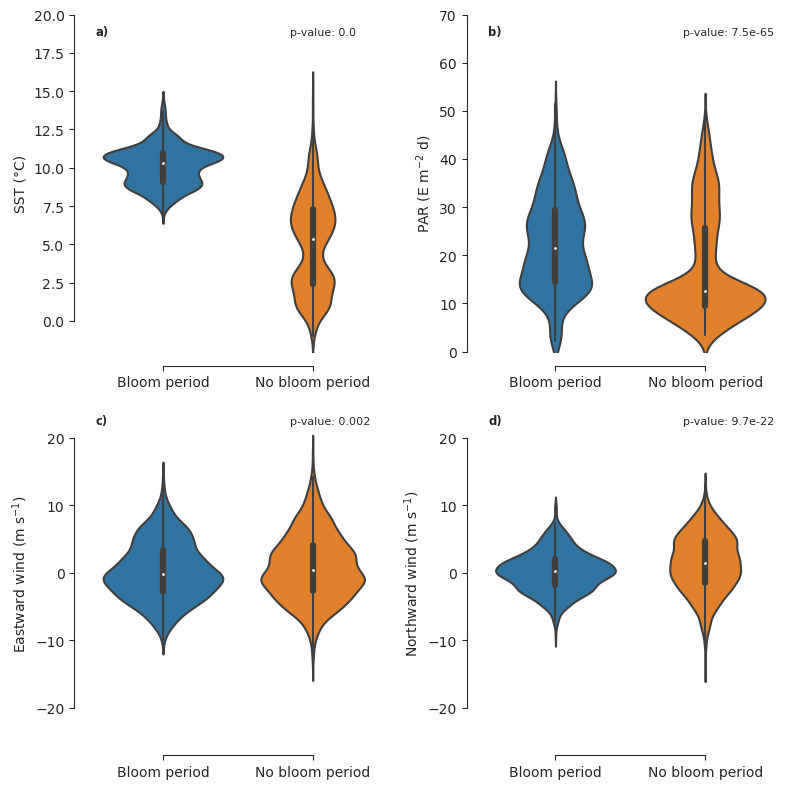

In [6]:
# library
import seaborn as sns
import matplotlib.pyplot as plt
import string
import warnings
warnings.filterwarnings("ignore")

# plot
sns.set_style("ticks")
fig = plt.figure(figsize=(8, 8))
i = 1
for var, ylim, xlim, ylabel in zip(["sst", "par", "eastward_wind", "northward_wind"],
                                   [(-2, 20), (0, 70), (-25, 25), (-25, 25)], 
                                   [(0, 0.3), (0, 0.15), (0, 0.4), (0, 0.4)],
                                   ["SST (°C)", "PAR (E m$^{-2}$ d)", "Eastward wind (m s$^{-1}$)", "Northward wind (m s$^{-1})$"]):
    if var == "flow":
        continue

    subset_bloom = df_aux_bloom[[var]]
    subset_bloom["hue"] = "Bloom period"
    
    subset_nobloom = df_aux_nobloom[[var]]
    subset_nobloom["hue"] = "No bloom period"
    subset = subset_bloom.append(subset_nobloom, ignore_index=True)
    
    ax = plt.subplot(2, 2, i)
    sns.violinplot(data=subset, x="hue", y=var,
            ax=ax)
    ax.set_ylim(ylim)
    sns.despine(offset=10, trim=True)
    
    pvalue = str(mannw_df.loc[var,:][0])
    if "e" in pvalue:
        pvalue1 = pvalue.split("e")[0][0:3]
        pvalue2 = "e"+pvalue.split("e")[1]
        pvalue = pvalue1+pvalue2
        
    else:
        pvalue = pvalue[0:5]

    ax.text(0.85,
            ((ax.get_ybound()[1]-ax.get_ybound()[0])*0.94)+ax.get_ybound()[0],
            "p-value: "+pvalue,
            horizontalalignment='left',
            fontsize=8)
    
    ax.text(-0.45,
            ((ax.get_ybound()[1]-ax.get_ybound()[0])*0.94)+ax.get_ybound()[0],
            string.ascii_lowercase[i-1]+")",
            fontsize="small",
            fontweight='bold')
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)
    
    i = i+1
    
plt.tight_layout()
fig.savefig(path_out_fig, dpi=300)

# 7. Range table

### 7.1 Bloom range

In [7]:
df_aux_bloom.describe(percentiles=[0.025, 0.975]).round(1)

,par,sst,eastward_wind,northward_wind
count,1075.0,1075.0,1075.0,1075.0
mean,22.4,10.1,0.3,0.2
std,9.7,1.3,4.3,2.9
min,2.3,7.0,-9.9,-9.4
2.5%,3.7,7.8,-7.4,-5.3
50%,21.5,10.3,-0.2,0.2
97.5%,41.1,12.7,9.2,6.3
max,51.4,14.4,14.3,9.8


### 7.2 No bloom range

In [8]:
df_aux_nobloom.describe(percentiles=[0.025, 0.975]).round(1)

,par,sst,eastward_wind,northward_wind
count,3255.0,3539.0,3539.0,3539.0
mean,17.3,5.0,0.8,1.5
std,10.9,3.0,4.9,4.3
min,3.5,-1.0,-14.1,-14.5
2.5%,4.3,0.2,-7.8,-7.3
50%,12.7,5.3,0.4,1.5
97.5%,42.3,10.8,11.1,9.1
max,49.3,15.1,18.5,13.1
